In [1]:
import h5py
import numpy as np
import os,random
from tensorflow.keras.layers import Input,Add,Reshape,AveragePooling2D,ZeroPadding2D,BatchNormalization,MaxPool2D,Conv1D,Conv2D,Dropout,Flatten,Dense,Activation,MaxPooling2D,AlphaDropout
from tensorflow.keras import layers
import tensorflow.keras.models as Model
from tensorflow.keras.regularizers import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import GlorotUniform as glorot_uniform
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
import tensorflow_addons as tfa

In [2]:
f = h5py.File('../ExtractDataset/part0.h5')
sample_num = f['X'].shape[0]
idx = np.random.choice(range(0,sample_num),size=30000)
# idx = np.random.choice(range(0,sample_num),size=60000)
X = f['X'][:][idx]
Y = f['Y'][:][idx]
Z = f['Z'][:][idx]
f.close()

for i in range(1,24):
#     if i%1 == 0:
#         !free -m
    '''if i == 10:
        continue'''
    filename = '../ExtractDataset/part'+str(i) + '.h5'
    print(filename)
    f = h5py.File(filename,'r')
    X = np.vstack((X,f['X'][:][idx]))
    Y = np.vstack((Y,f['Y'][:][idx]))
    Z = np.vstack((Z,f['Z'][:][idx]))
    f.close()

print('X-size：',X.shape)
print('Y-size：',Y.shape)
print('Z-size：',Z.shape)

../ExtractDataset/part1.h5
../ExtractDataset/part2.h5
../ExtractDataset/part3.h5
../ExtractDataset/part4.h5
../ExtractDataset/part5.h5
../ExtractDataset/part6.h5
../ExtractDataset/part7.h5
../ExtractDataset/part8.h5
../ExtractDataset/part9.h5
../ExtractDataset/part10.h5
../ExtractDataset/part11.h5
../ExtractDataset/part12.h5
../ExtractDataset/part13.h5
../ExtractDataset/part14.h5
../ExtractDataset/part15.h5
../ExtractDataset/part16.h5
../ExtractDataset/part17.h5
../ExtractDataset/part18.h5
../ExtractDataset/part19.h5
../ExtractDataset/part20.h5
../ExtractDataset/part21.h5
../ExtractDataset/part22.h5
../ExtractDataset/part23.h5
X-size： (720000, 1024, 2)
Y-size： (720000, 24)
Z-size： (720000, 1)


## Data preprocessing, and obtain training set and test set

In [3]:
n_examples = X.shape[0]
# n_train = int(n_examples * 0.9877) 
n_train = int(n_examples * 0.8)  
train_idx = np.random.choice(range(0,n_examples), size=n_train, replace=False)  #Randomly select training sample subscript
test_idx = list(set(range(0,n_examples))-set(train_idx)) #Test sample index
X_train = X[train_idx]  #training samples
X_test =  X[test_idx]  #testing samples
Y_train = Y[train_idx]
Y_test = Y[test_idx]
print("X_train:",X_train.shape)
print("Y_train:",Y_train.shape)
print("X_test:",X_test.shape)
print("Y_test:",Y_test.shape)

X_train: (576000, 1024, 2)
Y_train: (576000, 24)
X_test: (144000, 1024, 2)
Y_test: (144000, 24)


In [4]:
X_train[0]

array([[-0.3498382 ,  0.8699158 ],
       [-0.5654746 , -1.3332437 ],
       [ 0.01429884,  0.30088666],
       ...,
       [-1.4583069 , -0.3358951 ],
       [ 0.42157212, -0.1281802 ],
       [ 0.23045674,  0.508131  ]], dtype=float32)

In [5]:
X_train.shape[1:] 
# Input(in_shp)

(1024, 2)

In [6]:
units = round((X_train.shape[0])/(0.2*(X_train.shape[1]+X_train.shape[2])))
units/7

401.0

In [7]:
# #FULL RESNET
# def identity_block(X, f, filters, stage, block):
#     """
#     Implementation of the identity block as defined in Figure 3
    
#     Arguments:
#     X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
#     f -- integer, specifying the shape of the middle CONV's window for the main path
#     filters -- python list of integers, defining the number of filters in the CONV layers of the main path
#     stage -- integer, used to name the layers, depending on their position in the network
#     block -- string/character, used to name the layers, depending on their position in the network
    
#     Returns:
#     X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
#     """
    
#     # defining name basis
#     conv_name_base = 'res' + str(stage) + block + '_branch'
#     bn_name_base = 'bn' + str(stage) + block + '_branch'
    
#     # Retrieve Filters
#     F1, F2, F3 = filters
    
#     # Save the input value. You'll need this later to add back to the main path. 
#     X_shortcut = X
    
#     # First component of main path
#     X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0),data_format="channels_first")(X)
#     X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
#     X = Activation('relu')(X)

    
#     # Second component of main path (≈3 lines)
#     X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0),data_format="channels_first")(X)
#     X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
#     X = Activation('relu')(X)

#     # Third component of main path (≈2 lines)
#     X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0),data_format="channels_first")(X)
#     X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

#     # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
#     X = Add()([X, X_shortcut])
#     X = Activation('relu')(X)
    
    
#     return X

# def convolutional_block(X, f, filters, stage, block, s = 2):

#     """
#     Implementation of the convolutional block as defined in Figure 4
    
#     Arguments:
#     X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
#     f -- integer, specifying the shape of the middle CONV's window for the main path
#     filters -- python list of integers, defining the number of filters in the CONV layers of the main path
#     stage -- integer, used to name the layers, depending on their position in the network
#     block -- string/character, used to name the layers, depending on their position in the network
#     s -- Integer, specifying the stride to be used
    
#     Returns:
#     X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
#     """
    
#     # defining name basis
#     conv_name_base = 'res' + str(stage) + block + '_branch'
#     bn_name_base = 'bn' + str(stage) + block + '_branch'
    
#     # Retrieve Filters
#     F1, F2, F3 = filters
    
#     # Save the input value
#     X_shortcut = X


#     ##### MAIN PATH #####
#     # First component of main path 
#     X = Conv2D(F1, (1, 1), strides = (s,s), name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0),data_format="channels_first")(X)
#     X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
#     X = Activation('relu')(X)

#     # Second component of main path (≈3 lines)
#     X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0),data_format="channels_first")(X)
#     X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
#     X = Activation('relu')(X)


#     # Third component of main path (≈2 lines)
#     X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0),data_format="channels_first")(X)
#     X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)


#     ##### SHORTCUT PATH #### (≈2 lines)
#     X_shortcut = Conv2D(filters = F3, kernel_size = (1, 1), strides = (s,s), padding = 'valid', name = conv_name_base + '1',
#                         kernel_initializer = glorot_uniform(seed=0),data_format="channels_first")(X_shortcut)
#     X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)

#     # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
#     X = Add()([X, X_shortcut])
#     X = Activation('relu')(X)
    
    
#     return X

# def ResNet50(input_shape=(64, 64, 3), classes=6):
#     """
#     Implementation of the popular ResNet50 the following architecture:
#     CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
#     -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> TOPLAYER

#     Arguments:
#     input_shape -- shape of the images of the dataset
#     classes -- integer, number of classes

#     Returns:
#     model -- a Model() instance in Keras
#     """
#     mirrored_strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0","/gpu:1","/gpu:2"], cross_device_ops=tf.distribute.HierarchicalCopyAllReduce())
#     with mirrored_strategy.scope():
#         # Define the input as a tensor with shape input_shape
#         X_input = Input(input_shape)
#         X = Reshape([1,1024,2], input_shape=in_shp)(X_input)

#         # Zero-Padding
#         X = ZeroPadding2D((3, 3))(X)

#         # Stage 1
#         X = Conv2D(64, (7, 7), strides=(2, 2), name='conv1', kernel_initializer=glorot_uniform(seed=0))(X)
#         X = BatchNormalization(axis=3, name='bn_conv1')(X)
#         X = Activation('relu')(X)
#         X = MaxPooling2D((3, 3), strides=(2, 2),data_format="channels_first")(X)

#         # Stage 2
#         X = convolutional_block(X, f=3, filters=[64, 64, 256], stage=2, block='a', s=1)
#         X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
#         X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')

#         ### START CODE HERE ###

#         # Stage 3 (≈4 lines)
#         X = convolutional_block(X, f = 3, filters = [128, 128, 512], stage = 3, block='a', s = 2)
#         X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
#         X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
#         X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

#         # Stage 4 (≈6 lines)
#         X = convolutional_block(X, f = 3, filters = [256, 256, 1024], stage = 4, block='a', s = 2)
#         X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
#         X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
#         X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
#         X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
#         X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

#         # Stage 5 (≈3 lines)
#         X = convolutional_block(X, f = 3, filters = [512, 512, 2048], stage = 5, block='a', s = 2)
#         X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
#         X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

#         # AVGPOOL (≈1 line). Use "X = AveragePooling2D(...)(X)"
#         X = AveragePooling2D((2,2), name="avg_pool")(X)

#         ### END CODE HERE ###

#         # output layer
#         X = Flatten()(X)
#         X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)


#         # Create model
#         model = Model.Model(inputs = X_input, outputs = X, name='ResNet50')

#     return model

In [8]:
# classes = ['32PSK',
#  '16APSK',
#  '32QAM',
#  'FM',
#  'GMSK',
#  '32APSK',
#  'OQPSK',
#  '8ASK',
#  'BPSK',
#  '8PSK',
#  'AM-SSB-SC',
#  '4ASK',
#  '16PSK',
#  '64APSK',
#  '128QAM',
#  '128APSK',
#  'AM-DSB-SC',
#  'AM-SSB-WC',
#  '64QAM',
#  'QPSK',
#  '256QAM',
#  'AM-DSB-WC',
#  'OOK',
#  '16QAM']

   
# in_shp = X_train.shape[1:]   #Dimensions of each sample
# model = ResNet50(input_shape = in_shp, classes = 24)
# model.compile(loss='categorical_crossentropy', optimizer=tfa.optimizers.LazyAdam(),metrics=['accuracy'])
# model.summary()

In [9]:
classes = ['32PSK',
 '16APSK',
 '32QAM',
 'FM',
 'GMSK',
 '32APSK',
 'OQPSK',
 '8ASK',
 'BPSK',
 '8PSK',
 'AM-SSB-SC',
 '4ASK',
 '16PSK',
 '64APSK',
 '128QAM',
 '128APSK',
 'AM-DSB-SC',
 'AM-SSB-WC',
 '64QAM',
 'QPSK',
 '256QAM',
 'AM-DSB-WC',
 'OOK',
 '16QAM']

   
def residual_stack(X,Filters,Seq,max_pool):
    #1*1 Conv Linear
    X = Conv2D(Filters, (1, 1), padding='same', name=Seq+"_conv1", kernel_initializer='glorot_uniform',data_format="channels_first")(X)
    X = BatchNormalization(axis = 3)(X)

    #Residual Unit 1
    X_shortcut = X
    X = Conv2D(Filters, (3, 2), padding='same',activation="relu",name=Seq+"_conv2", kernel_initializer='glorot_uniform',data_format="channels_first")(X)
    X = Conv2D(Filters, (3, 2), padding='same', name=Seq+"_conv3", kernel_initializer='glorot_uniform',data_format="channels_first")(X)
    X = BatchNormalization(axis = 3)(X)

    X = layers.add([X,X_shortcut])
    X = Activation("relu")(X)
    #Residual Unit 2
    X_shortcut = X
    X = Conv2D(Filters, (3, 2), padding='same',activation="relu",name=Seq+"_conv4", kernel_initializer='glorot_uniform',data_format="channels_first")(X)
    X = Conv2D(Filters, (3, 2), padding='same', name=Seq+"_conv5", kernel_initializer='glorot_uniform',data_format="channels_first")(X)
    X = BatchNormalization(axis = 3)(X)

    
    X = layers.add([X,X_shortcut])
    X = Activation("relu")(X)
    #MaxPooling
    if max_pool:
        X = MaxPooling2D(pool_size=(2, 1), strides=(2, 1), padding='valid', data_format="channels_first")(X)
    return X

mirrored_strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0"], cross_device_ops=tf.distribute.HierarchicalCopyAllReduce())

with mirrored_strategy.scope():
    in_shp = X_train.shape[1:]   #Dimensions of each sample
    #input layer
    X_input = Input(in_shp)
    X = Reshape([1,1024,2], input_shape=in_shp)(X_input)
    #Residual Srack 1
    X = residual_stack(X,32,"ReStk1",False)  #shape:(1,512,32)
    X = MaxPooling2D(pool_size=(2, 2), strides=(2, 1), padding='valid', data_format="channels_first")(X)
    #Residual Srack 2
    X = residual_stack(X,32,"ReStk2",True)  #shape:(1,256,32)
    #Residual Srack 3
    X = residual_stack(X,64,"ReStk3",True)  #shape:(1,128,32)
    #Residual Srack 4
    X = residual_stack(X,64,"ReStk4",True)  #shape:(1,64,32)
    #Residual Srack 5
    # X = residual_stack(X,32,"ReStk5",True)  #shape:(1,32,32)
    # #Residual Srack 6
    # X = residual_stack(X,32,"ReStk6",True)  #shape:(1,16,32)
    #Full Con 1
    X = Flatten()(X)
    X = Dense(128, activation='selu', kernel_initializer='he_normal', name="dense1")(X)
    X = Dropout(0.3)(X)
    #Full Con 2
    X = Dense(128, activation='selu', kernel_initializer='he_normal', name="dense2")(X)
    X = Dropout(0.3)(X)
    #Full Con 3
    X = Dense(len(classes), kernel_initializer='he_normal', name="dense3")(X)
    #SoftMax
    X = Activation('softmax')(X)
    #Create Model
    model = Model.Model(inputs=X_input,outputs=X)
model.load_weights('resnet2_model.h5')
model.compile(loss='categorical_crossentropy', optimizer=tfa.optimizers.LazyAdam(),metrics=['accuracy'])
model.summary()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/

In [10]:
from tensorflow.keras.utils import plot_model
model = load_model('resnet_model_mix.h5')
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [11]:
%%time
filepath = 'resnet_model_mix.h5'
history = model.fit(X_train,
    Y_train,
    batch_size=1024,
    epochs=100,
    verbose=1,
#     validation_data=(X_test, Y_test),
    validation_split = 0.2,
    callbacks = [
        tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='auto'),
#         tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto')
    ])

Epoch 1/100
450/450 [==============================] - 228s 500ms/step - loss: 1.2404 - accuracy: 0.5952 - val_loss: 1.2236 - val_accuracy: 0.5982

Epoch 00001: val_loss improved from inf to 1.22356, saving model to resnet_model_mix.h5
Epoch 2/100


C:\Users\Aperture\anaconda3\envs\radioml_tf\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


450/450 [==============================] - 225s 500ms/step - loss: 1.2236 - accuracy: 0.6020 - val_loss: 1.2096 - val_accuracy: 0.6056

Epoch 00002: val_loss improved from 1.22356 to 1.20956, saving model to resnet_model_mix.h5
Epoch 3/100
450/450 [==============================] - 225s 500ms/step - loss: 1.2133 - accuracy: 0.6064 - val_loss: 1.2050 - val_accuracy: 0.6083

Epoch 00003: val_loss improved from 1.20956 to 1.20500, saving model to resnet_model_mix.h5
Epoch 4/100
450/450 [==============================] - 225s 501ms/step - loss: 1.2037 - accuracy: 0.6100 - val_loss: 1.2152 - val_accuracy: 0.6032

Epoch 00004: val_loss did not improve from 1.20500
Epoch 5/100
450/450 [==============================] - 226s 501ms/step - loss: 1.1908 - accuracy: 0.6155 - val_loss: 1.2262 - val_accuracy: 0.6011

Epoch 00005: val_loss did not improve from 1.20500
Epoch 6/100
450/450 [==============================] - 225s 501ms/step - loss: 1.1797 - accuracy: 0.6206 - val_loss: 1.2087 - val_accu

450/450 [==============================] - 223s 496ms/step - loss: 0.9852 - accuracy: 0.6919 - val_loss: 1.2772 - val_accuracy: 0.6340

Epoch 00042: val_loss did not improve from 1.20255
Epoch 43/100
450/450 [==============================] - 223s 496ms/step - loss: 0.9777 - accuracy: 0.6940 - val_loss: 1.2893 - val_accuracy: 0.6359

Epoch 00043: val_loss did not improve from 1.20255
Epoch 44/100
450/450 [==============================] - 223s 496ms/step - loss: 0.9771 - accuracy: 0.6943 - val_loss: 1.2901 - val_accuracy: 0.6336

Epoch 00044: val_loss did not improve from 1.20255
Epoch 45/100
450/450 [==============================] - 223s 496ms/step - loss: 0.9722 - accuracy: 0.6960 - val_loss: 1.2819 - val_accuracy: 0.6358

Epoch 00045: val_loss did not improve from 1.20255
Epoch 46/100
450/450 [==============================] - 223s 496ms/step - loss: 0.9725 - accuracy: 0.6958 - val_loss: 1.2773 - val_accuracy: 0.6364

Epoch 00046: val_loss did not improve from 1.20255
Epoch 47/100


450/450 [==============================] - 223s 496ms/step - loss: 0.8839 - accuracy: 0.7237 - val_loss: 1.3639 - val_accuracy: 0.6468

Epoch 00083: val_loss did not improve from 1.20255
Epoch 84/100
450/450 [==============================] - 223s 496ms/step - loss: 0.8821 - accuracy: 0.7245 - val_loss: 1.3355 - val_accuracy: 0.6531

Epoch 00084: val_loss did not improve from 1.20255
Epoch 85/100
450/450 [==============================] - 223s 496ms/step - loss: 0.8803 - accuracy: 0.7251 - val_loss: 1.3518 - val_accuracy: 0.6495

Epoch 00085: val_loss did not improve from 1.20255
Epoch 86/100
450/450 [==============================] - 223s 496ms/step - loss: 0.8792 - accuracy: 0.7256 - val_loss: 1.3487 - val_accuracy: 0.6452

Epoch 00086: val_loss did not improve from 1.20255
Epoch 87/100
450/450 [==============================] - 223s 496ms/step - loss: 0.8779 - accuracy: 0.7256 - val_loss: 1.3573 - val_accuracy: 0.6480

Epoch 00087: val_loss did not improve from 1.20255
Epoch 88/100


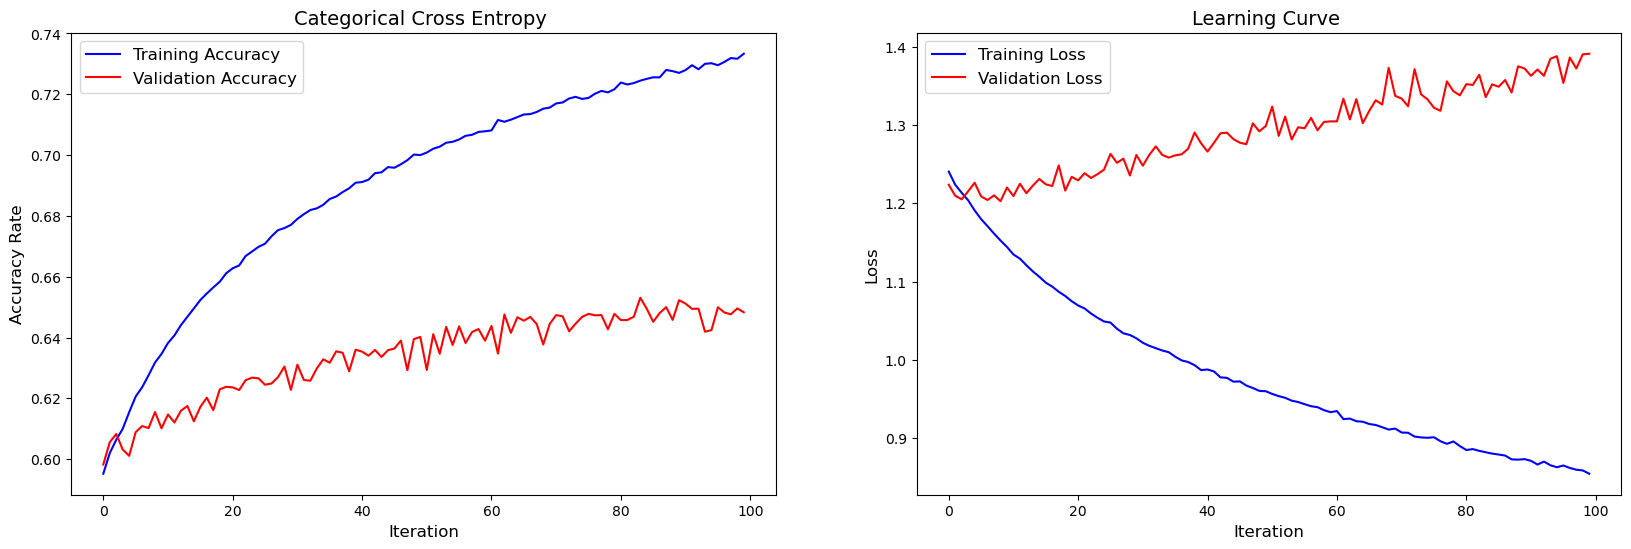

In [12]:
fig, ((ax1, ax2)) = plt.subplots(nrows=1, ncols=2,figsize=(20,6))

ax1.plot(history.history['accuracy'],'b', history.history['val_accuracy'], 'r')
ax1.set_ylabel('Accuracy Rate',fontsize=12)
ax1.set_xlabel('Iteration',fontsize=12)
ax1.set_title('Categorical Cross Entropy ',fontsize=14)
ax1.legend(['Training Accuracy','Validation Accuracy'],fontsize=12,loc='best')

ax2.plot(history.history['loss'], 'b',history.history['val_loss'],'r')
ax2.set_ylabel('Loss',fontsize=12)
ax2.set_xlabel('Iteration',fontsize=12)
ax2.set_title('Learning Curve ',fontsize=14)
ax2.legend(['Training Loss','Validation Loss'],fontsize=12,loc='best')

# plt.savefig('crosse_results.png')
plt.show()

In [13]:
model = load_model(filepath)

In [14]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=[]):
    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
# Plot confusion matrix
batch_size = 1024
test_Y_hat = model.predict(X_test, batch_size=3000)
conf = np.zeros([len(classes),len(classes)])
confnorm = np.zeros([len(classes),len(classes)])
for i in range(0,X_test.shape[0]):
    j = list(Y_test[i,:]).index(1)
    k = int(np.argmax(test_Y_hat[i,:]))
    conf[j,k] = conf[j,k] + 1
for i in range(0,len(classes)):
    confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
plot_confusion_matrix(confnorm, labels=classes)

ResourceExhaustedError:  OOM when allocating tensor with shape[3000,32,1024,3] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node functional_1/ReStk1_conv2/Relu (defined at <ipython-input-14-eeb1cbd8bdb2>:14) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_predict_function_124625]

Function call stack:
predict_function


In [ ]:
for i in range(len(confnorm)):
    print(classes[i],confnorm[i,i])

In [ ]:

acc={}
Z_test = Z[test_idx]
Z_test = Z_test.reshape((len(Z_test)))
SNRs = np.unique(Z_test)
for snr in SNRs:
    X_test_snr = X_test[Z_test==snr]
    Y_test_snr = Y_test[Z_test==snr]
    
    pre_Y_test = model.predict(X_test_snr)
    conf = np.zeros([len(classes),len(classes)])
    confnorm = np.zeros([len(classes),len(classes)])
    for i in range(0,X_test_snr.shape[0]):    #该信噪比下测试数据量
        j = list(Y_test_snr[i,:]).index(1)   #正确类别下标
        k = int(np.argmax(pre_Y_test[i,:])) #预测类别下标
        conf[j,k] = conf[j,k] + 1
    for i in range(0,len(classes)):
        confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
   
    plt.figure()
    plot_confusion_matrix(confnorm, labels=classes, title="ConvNet Confusion Matrix (SNR=%d)"%(snr))
    
    cor = np.sum(np.diag(conf))
    ncor = np.sum(conf) - cor
    print ("Overall Accuracy %s: "%snr, cor / (cor+ncor))
    acc[snr] = 1.0*cor/(cor+ncor)

In [ ]:
plt.figure(figsize=(8,6))
plt.plot(acc.keys(),acc.values(),linewidth=4,color='lightgreen', marker='D', markeredgecolor='black')
plt.ylim(0, 1) 
plt.ylabel('Accuracy')
plt.xlabel('SNR')
plt.title('Resnet 4 Stack (Modified)')
plt.grid()
plt.legend(['Resnet'],loc='upper left')
plt.show()

In [ ]:

plt.plot(acc.keys(),acc.values())
plt.ylabel('ACC')
plt.xlabel('SNR')
plt.grid(True)
plt.show()